# Heart Disease Classification

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

## Data Reading

In [2]:
# Read data from the downloaded csv file
heart = pd.read_csv("heart.csv")

# 1. Exploratory Data Analysis

## 1.1 Data Inspection

In [3]:
# View the top records of the data
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# View the dimensions of the data
heart.shape

(918, 12)

The data has 918 rows and 12 columns

In [5]:
# View the features of the data
heart.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [6]:
# View the information of the data 
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


According to description on kaggle the variables carries the following meaning

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

All the features are important clinical information that used in previous research works

From the description, it could be identified that there are some categorical variables that need to be encoded before modelling phase 

## 1.2 Data Cleaning

In [7]:
# Check if there is column with null value
heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There is no missing value in the dataset. The dataset is clean

## 1.3 Outlier Detection

Text(0.5, 1.0, 'RestingBP Boxplot')

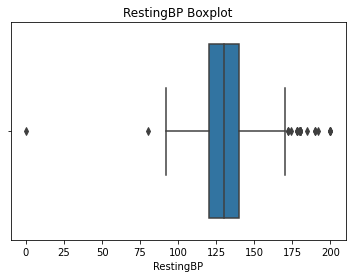

In [8]:
# Create a box plot for Resting BP
sns.boxplot(data = heart, x="RestingBP")
plt.title('RestingBP Boxplot')

From the boxplot above, outlier is detected. The variable should be further inspected

In [9]:
# View statistical properties of Resting BP
heart["RestingBP"].describe()

count    918.000000
mean     132.396514
std       18.514154
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64

The min value for the Resting Blood Pressure is 0. This should be impossible. Observations with 0 RestingBP is inspected.

In [10]:
# Filter record with RestingBP equals to 0
heart[heart["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


There is only one observation. This observation will be removed

In [11]:
# Remove the record that has 0 Resting BP
heart = heart[heart["RestingBP"] != 0]

Text(0.5, 1.0, 'RestingBP Boxplot')

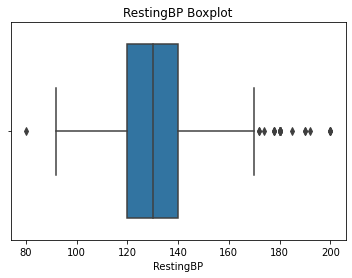

In [12]:
# Create a box plot for Resting BP
sns.boxplot(data = heart, x="RestingBP")
plt.title('RestingBP Boxplot')

The distribution changed significantly. This has justified the removal. The reason for that outlier presence could be measurement error or other systematic error.

## 1.4 Data Understanding

In [13]:
# View number of records for each label
print(heart["HeartDisease"].value_counts())

# Compute the percentage of records for each label
perc_of_classes = heart["HeartDisease"].value_counts().values / len(heart) * 100
print("Percentage of class with heart diseases : {:.2f} %".format(perc_of_classes[0]))
print("Percentage of class normal : {:.2f} %".format(perc_of_classes[1]))

1    507
0    410
Name: HeartDisease, dtype: int64
Percentage of class with heart diseases : 55.29 %
Percentage of class normal : 44.71 %


Text(0.5, 1.0, 'Number of observations per class')

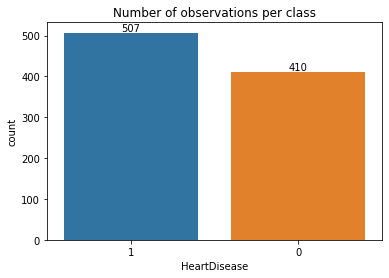

In [14]:
# Generate a bar plot showing No of records per label
target_counts = heart['HeartDisease'].value_counts().values

# Create the labels for the bars
bc = sns.countplot(x="HeartDisease", data=heart, order=heart['HeartDisease'].value_counts().index)
bc.bar_label(container=bc.containers[0], labels=target_counts)
plt.title('Number of observations per class')

The number of observations that has label 0 and 1 are almost equal (44.71 % and 55.29 %). The dataset is a balanced dataset.

Average age : 53.51


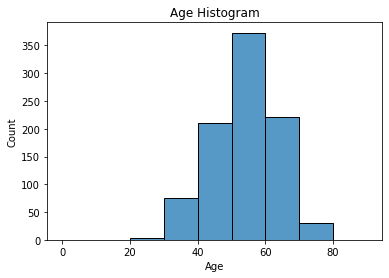

In [15]:
# Create the histogram for Age
sns.histplot(heart, x = "Age",  bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.title('Age Histogram')

# Compute the mean age
print("Average age : {:.2f}".format(heart["Age"].mean()))

Average age for observations without heart disease: 50.55
Average age for observations with heart disease: 55.90


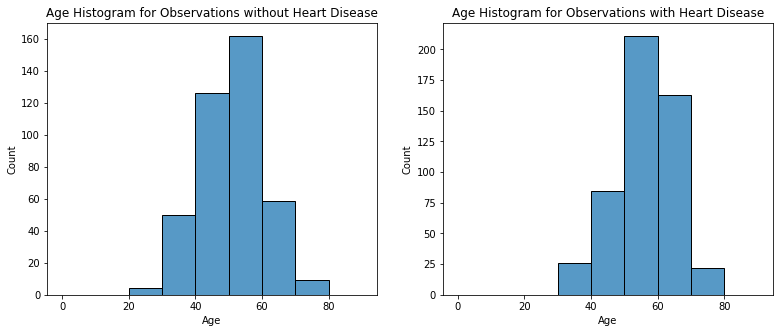

In [16]:
#  Create the histogram of age for records without heart disease
plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
sns.histplot(heart[heart['HeartDisease'] == 0], x="Age", bins=[0, 10, 20, 30, 40, 
                                                               50, 60, 70, 80, 90])

plt.title('Age Histogram for Observations without Heart Disease')

#  Create the histogram of age for records with heart disease
plt.subplot(1, 2, 2)
sns.histplot(heart[heart['HeartDisease'] == 1], x="Age", bins=[0, 10, 20, 30, 40, 
                                                               50, 60, 70, 80, 90])
plt.title('Age Histogram for Observations with Heart Disease')

# Compute the mean of age for records without and with heart disease
print("Average age for observations without heart disease: {:.2f}".format(
    heart[heart['HeartDisease'] == 0]["Age"].mean()))
print("Average age for observations with heart disease: {:.2f}".format(
    heart[heart['HeartDisease'] == 1]["Age"].mean()))

From the histograms, there is not a clear pattern that could be observed. But at least it could be observed that for a person between 50-60 years old, the proportion of getting a heart disease and not getting is about equal.
It could be observed that 60-70 years old have higher risk for getting heart diseases.
The average age of people who have heart disease is slightly older than those without.

Text(0.5, 1.0, 'Number of Observations per Chest Pain')

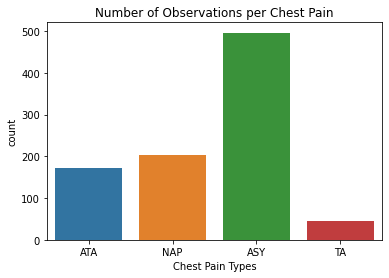

In [17]:
# Generate a bar plot showing No of records per chest pain
bc = sns.countplot(x="ChestPainType", data=heart)
plt.xlabel("Chest Pain Types")
plt.title('Number of Observations per Chest Pain')

Asymptomatic (ASY) chest pain is the most common type of chest pain

Text(0.5, 1.0, 'Number of Heart Disease Presences per Chest Pain')

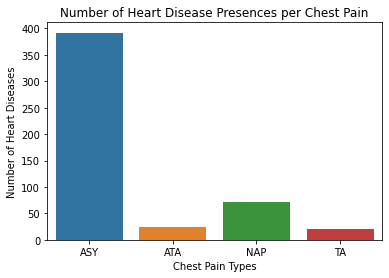

In [18]:
# Sum the value group by ChestPainType, this allow the total Heart Disease (with label 1) 
# to be computed
heart_gb_cp_sum = heart.groupby("ChestPainType").sum(numeric_only = True)

# Generate a bar plot showing No of Heart Diseases per chest pain
sns.barplot(x=heart_gb_cp_sum.index, y = "HeartDisease", data=heart_gb_cp_sum)
plt.xlabel("Chest Pain Types")
plt.ylabel("Number of Heart Diseases")
plt.title('Number of Heart Disease Presences per Chest Pain')

Asymptomatic (ASY) chest pain is the most common chest pain for people with heart disease, the proportion is significantly larger than other types of chest pain

Average Cholesterol for observations without heart disease: 227.12
Average Cholesterol for observations with heart disease: 176.29


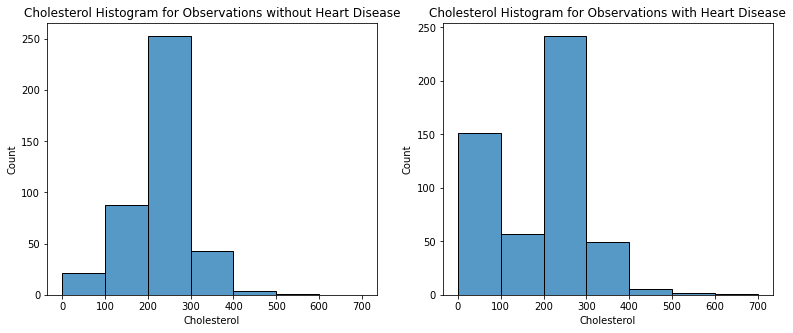

In [19]:
#  Create the histogram of cholesterol for records without heart disease
plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
sns.histplot(heart[heart['HeartDisease'] == 0], x="Cholesterol", bins=[0, 100, 200, 
                                                                       300, 400, 500, 600, 700])

plt.title('Cholesterol Histogram for Observations without Heart Disease')

#  Create the histogram of cholesterol for records with heart disease
plt.subplot(1, 2, 2)
sns.histplot(heart[heart['HeartDisease'] == 1], x="Cholesterol", bins=[0, 100, 200, 
                                                                       300, 400, 500, 600, 700])
plt.title('Cholesterol Histogram for Observations with Heart Disease')

#  Compute the mean of cholesterol for records without and with heart disease
print("Average Cholesterol for observations without heart disease: {:.2f}".format(
    heart[heart['HeartDisease'] == 0]["Cholesterol"].mean()))
print("Average Cholesterol for observations with heart disease: {:.2f}".format(
    heart[heart['HeartDisease'] == 1]["Cholesterol"].mean()))

People with heart disease has a mean serum cholesterol lower than normal people.

From the histogram, it could be observed that people with too low serum cholesterol (0-100 mm Hg), have a higher risk to have heart diseases. 

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

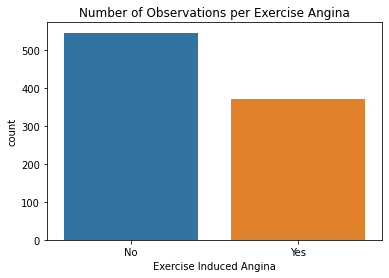

In [20]:
# Create bar plot showing no of observations per Exercise Angina
ax = sns.countplot(x="ExerciseAngina", data=heart)
plt.xlabel("Exercise Induced Angina")
plt.title('Number of Observations per Exercise Angina')
ax.set_xticklabels(['No', 'Yes'])

The number observations which has no exercise induced angine (a chest pain induced by exercise) is higher

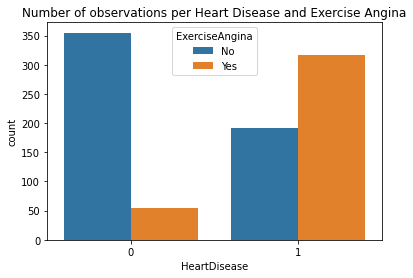

In [21]:
# Create bar plot showing no of observations per Exercise Angina and Heart Disease
ax = sns.countplot(x="HeartDisease", hue="ExerciseAngina" , data=heart)
plt.title('Number of observations per Heart Disease and Exercise Angina')
ax.legend(title='ExerciseAngina', labels=['No', 'Yes'])

People without heart disease mostly does not have exercise induced angina. While among people who have heart disease, the number of people who have exercise induced angina is higher

Average Oldpeak for observations without heart disease: 0.41
Average Oldpeak for observations with heart disease: 1.27


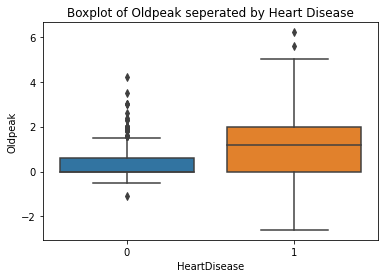

In [22]:
# Create boxplot of Oldpeak seperated by Heart Disease
sns.boxplot(x ='HeartDisease', y = "Oldpeak" , data =heart)
plt.title('Boxplot of Oldpeak seperated by Heart Disease')

#  Compute the mean of Oldpeak for records without and with heart disease
print("Average Oldpeak for observations without heart disease: {:.2f}".format(
    heart[heart['HeartDisease'] == 0]["Oldpeak"].mean()))
print("Average Oldpeak for observations with heart disease: {:.2f}".format(
    heart[heart['HeartDisease'] == 1]["Oldpeak"].mean()))

The average oldpeak for person without heart disease is lower

Average MaxHR for observations without heart disease: 148.15
Average MaxHR for observations with heart disease: 127.60


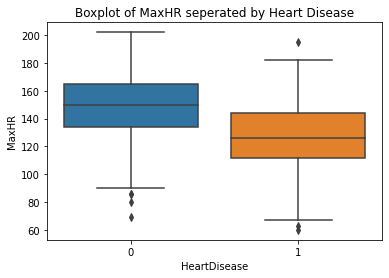

In [23]:
# Create boxplot of MaxHR seperated by Heart Disease
sns.boxplot(x ='HeartDisease', y = "MaxHR" , data =heart)
plt.title('Boxplot of MaxHR seperated by Heart Disease')

#  Compute the mean of MaxHR for records without and with heart disease
print("Average MaxHR for observations without heart disease: {:.2f}".format(
    heart[heart['HeartDisease'] == 0]["MaxHR"].mean()))
print("Average MaxHR for observations with heart disease: {:.2f}".format(
    heart[heart['HeartDisease'] == 1]["MaxHR"].mean()))

The average maximum heart rate achieved for person without heart disease is higher

Text(0.5, 1.0, 'Heatmap for Correlation of Heart Disease, MaxHR, and Oldpeak')

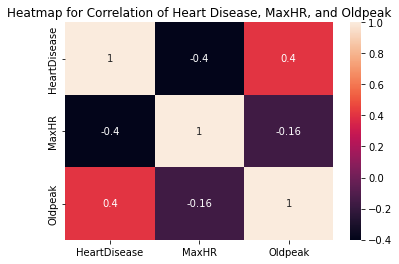

In [24]:
# Create heatmap showing correlation of MaxHR, Oldpeak and Heart Disease
sns.heatmap(heart[["HeartDisease","MaxHR","Oldpeak"]].corr(), annot=True)
plt.title('Heatmap for Correlation of Heart Disease, MaxHR, and Oldpeak')

The heatmap above very good summarise the information conveyed by the 2 boxplots above.

Both Oldpeak and MaxHR (maximum heart rate achieved) shows a moderate correlation (0.4) with heart disease

While the MaxHR is negative correlation and Oldpeak is positive correlation

Text(0.5, 1.0, 'Number of Observations per Heart Disease and ST_Slope')

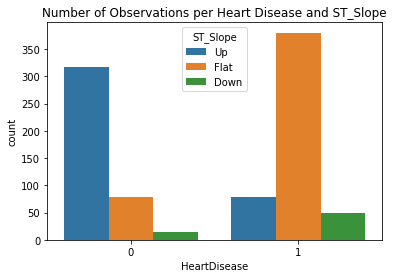

In [25]:
# Create bar plot showing no of observations per ST_Slope and Heart Disease
ax = sns.countplot(x="HeartDisease", hue="ST_Slope" , data=heart)
plt.title('Number of Observations per Heart Disease and ST_Slope')

It could be observed that for normal people, most of them have Up ST_Slope

While for people with heart disease, most of them have Flat ST_Slope

# 2. Data Preparation

## 2.1 Column Transformation

In [26]:
# View information of the data frame
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             917 non-null    int64  
 1   Sex             917 non-null    object 
 2   ChestPainType   917 non-null    object 
 3   RestingBP       917 non-null    int64  
 4   Cholesterol     917 non-null    int64  
 5   FastingBS       917 non-null    int64  
 6   RestingECG      917 non-null    object 
 7   MaxHR           917 non-null    int64  
 8   ExerciseAngina  917 non-null    object 
 9   Oldpeak         917 non-null    float64
 10  ST_Slope        917 non-null    object 
 11  HeartDisease    917 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 125.4+ KB


Some variable need to be encoded before the modelling phase

In [27]:
# view top records
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [28]:
# View possible values and its counts of sex
heart['Sex'].value_counts()

M    724
F    193
Name: Sex, dtype: int64

In [29]:
# View possible values and its counts of ExerciseAngina
heart['ExerciseAngina'].value_counts()

N    546
Y    371
Name: ExerciseAngina, dtype: int64

It has been confirmed that Sex and ExerciseAngina has 2 possible values only. For these kind of variables, LabelEncoder will be used

In [30]:
# Create label encoder
le = preprocessing.LabelEncoder()
  
# Encode sex and exerciseangina columns' values
heart['Sex']= le.fit_transform(heart['Sex'])
heart['ExerciseAngina']= le.fit_transform(heart['ExerciseAngina'])

In [31]:
# Check encoding result
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0


In [32]:
# Confirm encoding result
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             917 non-null    int64  
 1   Sex             917 non-null    int32  
 2   ChestPainType   917 non-null    object 
 3   RestingBP       917 non-null    int64  
 4   Cholesterol     917 non-null    int64  
 5   FastingBS       917 non-null    int64  
 6   RestingECG      917 non-null    object 
 7   MaxHR           917 non-null    int64  
 8   ExerciseAngina  917 non-null    int32  
 9   Oldpeak         917 non-null    float64
 10  ST_Slope        917 non-null    object 
 11  HeartDisease    917 non-null    int64  
dtypes: float64(1), int32(2), int64(6), object(3)
memory usage: 118.3+ KB


The transformation has been done successfully.

In [33]:
# View possible values and its counts of ChestPainType
heart['ChestPainType'].value_counts()

ASY    496
NAP    202
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [34]:
# View possible values and its counts of RestingECG
heart['RestingECG'].value_counts()

Normal    551
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [35]:
# View possible values and its counts of ST_Slope
heart['ST_Slope'].value_counts()

Flat    459
Up      395
Down     63
Name: ST_Slope, dtype: int64

It has been confimed that ChestPainType, RestingECG, and ST_Slope has 3 possible values. For categorical variables with more than 2 possible value. One hot encoding will be used. One hot encoding is preferred over Label Encoder as the latter will impose an order to the values which does not exist in real world domain.
https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

In [36]:
# Create Label Binarizer to implement one hot encoding
lb = preprocessing.LabelBinarizer()

# Encode ChestPainType column with Label Binarizer
heart = heart.join(pd.DataFrame(lb.fit_transform(heart["ChestPainType"]),
                          columns=lb.classes_, 
                          index=heart.index))

# Encode RestingECG column with Label Binarizer
heart = heart.join(pd.DataFrame(lb.fit_transform(heart["RestingECG"]),
                          columns=lb.classes_, 
                          index=heart.index))

# Encode STSlope column with Label Binarizer
heart = heart.join(pd.DataFrame(lb.fit_transform(heart["ST_Slope"]),
                          columns=lb.classes_, 
                          index=heart.index))

In [37]:
# Confirm encoding result
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             917 non-null    int64  
 1   Sex             917 non-null    int32  
 2   ChestPainType   917 non-null    object 
 3   RestingBP       917 non-null    int64  
 4   Cholesterol     917 non-null    int64  
 5   FastingBS       917 non-null    int64  
 6   RestingECG      917 non-null    object 
 7   MaxHR           917 non-null    int64  
 8   ExerciseAngina  917 non-null    int32  
 9   Oldpeak         917 non-null    float64
 10  ST_Slope        917 non-null    object 
 11  HeartDisease    917 non-null    int64  
 12  ASY             917 non-null    int32  
 13  ATA             917 non-null    int32  
 14  NAP             917 non-null    int32  
 15  TA              917 non-null    int32  
 16  LVH             917 non-null    int32  
 17  Normal          917 non-null    int

The transformation is successful. The original columns could be dropped.

In [38]:
# Drop the original columns that has been encode by LabelBinarizer
heart = heart.drop(columns=["ChestPainType", "RestingECG","ST_Slope"])

In [39]:
# Confirm dropping result
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             917 non-null    int64  
 1   Sex             917 non-null    int32  
 2   RestingBP       917 non-null    int64  
 3   Cholesterol     917 non-null    int64  
 4   FastingBS       917 non-null    int64  
 5   MaxHR           917 non-null    int64  
 6   ExerciseAngina  917 non-null    int32  
 7   Oldpeak         917 non-null    float64
 8   HeartDisease    917 non-null    int64  
 9   ASY             917 non-null    int32  
 10  ATA             917 non-null    int32  
 11  NAP             917 non-null    int32  
 12  TA              917 non-null    int32  
 13  LVH             917 non-null    int32  
 14  Normal          917 non-null    int32  
 15  ST              917 non-null    int32  
 16  Down            917 non-null    int32  
 17  Flat            917 non-null    int

All the columns now could be accepted by the model

Some of the columns created by One Hot Encoding need to be dropped. For each group of columns created with same feature, one of them should be dropped. This is because they carry redundant information.
For example, if the observation has 0 on ATA, NAP and TA. It signify it must have a 1 in ASY.
https://www.geeksforgeeks.org/ml-dummy-variable-trap-in-regression-models/

In [40]:
# Drop the columns with redundant information
# ASY ATA NAP TA - one of them should be dropped
# LVH Normal ST - one of them should be dropped
# Down Flat Up - one of them should be dropped

heart = heart.drop(columns=["ASY","ST","Down"])

## 2.2 Train Test Split

In [41]:
# Split the predictors and target variable
heart_X = heart.iloc[:, heart.columns != "HeartDisease"]
heart_y = heart["HeartDisease"]

The dataframe is splitted into X (independent variable) and y (target variable)

In [42]:
# Perform 70 : 30 train test split
heart_X_train, heart_X_test, heart_y_train, heart_y_test = train_test_split(
    heart_X, heart_y, test_size=0.30, random_state=123)

In [43]:
# View dimensions of traing data X
heart_X_train.shape

(641, 15)

The training data has 641 rows

In [44]:
# View dimensions of testing data X
heart_X_test.shape

(276, 15)

The testing data has 276 rows

# 3. Modelling

## 3.1 Random Forest

In [45]:
# using cross validation to find the optimal hyperparameter
scores = []
hyperparams = []

for n_estimator in [500,1000,2000]:
    for max_depth in [3,5,7]:
        for max_features in [2,3,4]:
            rf_clf = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, 
                                            random_state=0, max_features = max_features)
            cv_scores = cross_val_score(rf_clf, heart_X_train, heart_y_train, cv=5)
            scores.append(cv_scores.mean())
            hyperparams.append((n_estimator,max_depth,max_features))

In [46]:
# Show the best hyperparameter
best_hyperparam = hyperparams[np.argmax(scores)]
print("Optimal n_estimator : " + str(best_hyperparam[0]))
print("Optimal max_depth : " + str(best_hyperparam[1]))
print("Optimal max_features : " + str(best_hyperparam[2]))

Optimal n_estimator : 500
Optimal max_depth : 7
Optimal max_features : 2


In [47]:
# Creating Random Forest Model
rf_clf = RandomForestClassifier(n_estimators=500, max_depth=7, random_state=0, max_features = 2)

# Fitting the model to training data
rf_clf.fit(heart_X_train, heart_y_train)

RandomForestClassifier(max_depth=7, max_features=2, n_estimators=500,
                       random_state=0)

## 3.2 Support Vector Machine (SVM)

In [48]:
# using cross validation to find the optimal hyperparameter
scores = []
hyperparams = []

for C in [100,200,500,1000]:
    svm_clf = SVC(C= C)
    cv_scores = cross_val_score(svm_clf, heart_X_train, heart_y_train, cv=5)
    scores.append(cv_scores.mean())
    hyperparams.append((C))

In [49]:
# Show the best hyperparameter
best_hyperparam = hyperparams[np.argmax(scores)]
print("Optimal C : " + str(best_hyperparam))

Optimal C : 1000


In [50]:
# Creating SVM model
svm_clf = SVC(C= 1000)

# Fitting the model to training data
svm_clf.fit(heart_X_train, heart_y_train)

SVC(C=1000)

## 3.3 Logistic Regression

In [51]:
# using cross validation to find the optimal hyperparameter
scores = []
hyperparams = []

for C in [1,5,50,100]:
    for solver in ['lbfgs', 'liblinear', 'newton-cholesky']:
        lr_clf = LogisticRegression(C = C, random_state=0, solver=solver, max_iter = 5000)
        cv_scores = cross_val_score(lr_clf, heart_X_train, heart_y_train, cv=5)
        scores.append(cv_scores.mean())
        hyperparams.append((C, solver))

In [52]:
# Show the best hyperparameter
best_hyperparam = hyperparams[np.argmax(scores)]
print("Optimal C : " + str(best_hyperparam[0]))
print("Optimal solver : " + str(best_hyperparam[1]))

Optimal C : 1
Optimal solver : newton-cholesky


In [53]:
# Creating Logistic Regression model
lr_clf = LogisticRegression(random_state=0, solver="newton-cholesky", C = 1)

# Fitting the model to training data
lr_clf.fit(heart_X_train, heart_y_train)

LogisticRegression(C=1, random_state=0, solver='newton-cholesky')

# 4.0 Evaluation

## 4.1 Prediction

In [54]:
# Obtain the predictions of the models
rf_pred_y = rf_clf.predict(heart_X_test)
svm_pred_y = svm_clf.predict(heart_X_test)
lr_pred_y = lr_clf.predict(heart_X_test)

The predictions of the models are stored in the variables

Text(0.5, 1.0, 'Barchart of the predicted value per true label (Random Forest)')

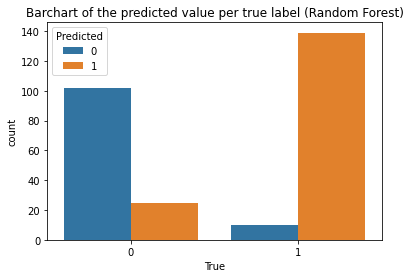

In [55]:
# Creating barchart that shows number of records per true label and prediction
df = pd.DataFrame({"Predicted" : rf_pred_y,"True" : heart_y_test})
ax = sns.countplot(x="True", hue="Predicted", data=df)
plt.title('Barchart of the predicted value per true label (Random Forest)')

Text(0.5, 1.0, 'Barchart of the predicted value per true label (SVM)')

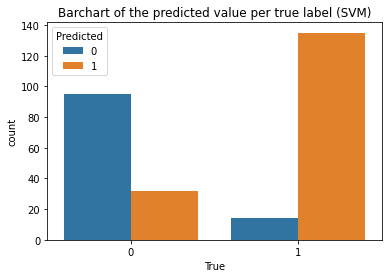

In [56]:
# Creating barchart that shows number of records per true label and prediction
df = pd.DataFrame({"Predicted" : svm_pred_y,"True" : heart_y_test})
ax = sns.countplot(x="True", hue="Predicted", data=df)
plt.title('Barchart of the predicted value per true label (SVM)')

Text(0.5, 1.0, 'Barchart of the predicted value per true label (Logistic Regression)')

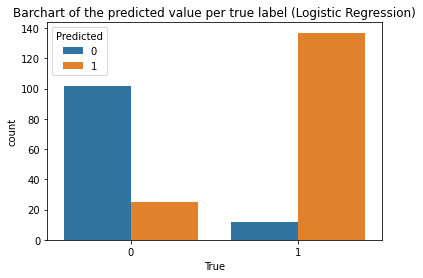

In [57]:
# Creating barchart that shows number of records per true label and prediction
df = pd.DataFrame({"Predicted" : lr_pred_y,"True" : heart_y_test})
ax = sns.countplot(x="True", hue="Predicted", data=df)
plt.title('Barchart of the predicted value per true label (Logistic Regression)')

## 4.2 Accuracy

In [58]:
# Compute the accuracy score of 3 models
rf_acc = accuracy_score(heart_y_test, rf_pred_y)
svm_acc = accuracy_score(heart_y_test, svm_pred_y)
lr_acc = accuracy_score(heart_y_test, lr_pred_y)

In [59]:
# Shows the accuracy for the 3 algorithms rounded off to 2 decimal place
print("The accuracy for Random Forest : " + str(round(rf_acc, 2)))
print("The accuracy for Support Vector Machine : " + str(round(svm_acc, 2)))
print("The accuracy for Logistic Regression : " + str(round(lr_acc, 2)))

The accuracy for Random Forest : 0.87
The accuracy for Support Vector Machine : 0.83
The accuracy for Logistic Regression : 0.87


Random Forest algorithm and Logistic Regression achieved the best accuracy, followed by Support Vector Machine

Text(0.5, 1.0, 'Accuracy of Algorithms')

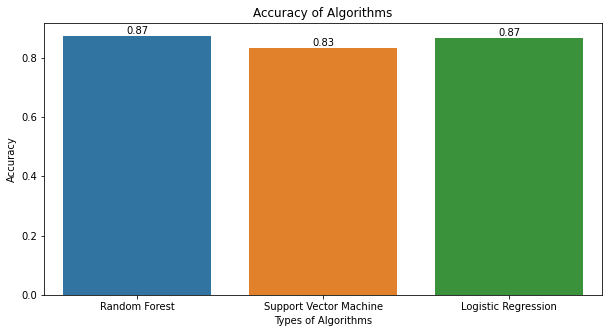

In [60]:
# Creating bar plot to show the accuracy score
algorithms = ["Random Forest", "Support Vector Machine", "Logistic Regression"]
plt.figure(figsize=(10,5))
bp = sns.barplot(x = algorithms,y = [rf_acc, svm_acc, lr_acc])
bp.bar_label(container=bp.containers[0], labels=[round(rf_acc, 2), 
                                                 round(svm_acc, 2), round(lr_acc, 2)])

plt.xlabel("Types of Algorithms")
plt.ylabel("Accuracy")
plt.title('Accuracy of Algorithms')

## 4.3 F1-score

In [61]:
# Compute the F1 score of 3 models
rf_f1 = f1_score(heart_y_test, rf_pred_y)
svm_f1 = f1_score(heart_y_test, svm_pred_y)
lr_f1 = f1_score(heart_y_test, lr_pred_y)

In [62]:
# Shows the F1 Score for the 3 algorithms rounded off to 2 decimal place
print("The F1 Score for Random Forest : " + str(round(rf_f1, 2)))
print("The F1 Score for Support Vector Machine : " + str(round(svm_f1, 2)))
print("The F1 Score for Logistic Regression : " + str(round(lr_f1, 2)))

The F1 Score for Random Forest : 0.89
The F1 Score for Support Vector Machine : 0.85
The F1 Score for Logistic Regression : 0.88


Random Forest algorithm achieved the best F1 Score, followed by Logistic Regression and Support Vector Machine

Text(0.5, 1.0, 'F1 Score of Algorithms')

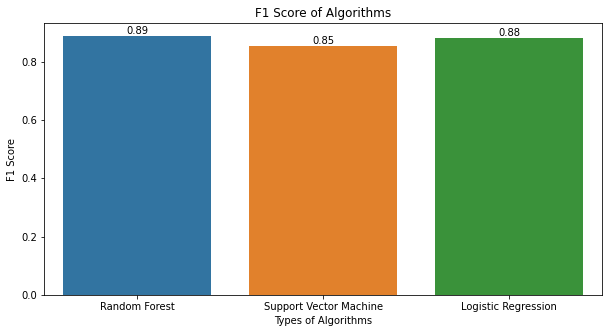

In [63]:
# Creating bar plot to show the F1 score
plt.figure(figsize=(10,5))
bp = sns.barplot(x = algorithms,y = [rf_f1, svm_f1, lr_f1])
bp.bar_label(container=bp.containers[0], labels=[round(rf_f1, 2), 
                                                 round(svm_f1, 2), round(lr_f1, 2)])

plt.xlabel("Types of Algorithms")
plt.ylabel("F1 Score")
plt.title('F1 Score of Algorithms')

## 4.4 Precision

In [64]:
# Compute the Precision score of 3 models
rf_prec = precision_score(heart_y_test, rf_pred_y)
svm_prec= precision_score(heart_y_test, svm_pred_y)
lr_prec = precision_score(heart_y_test, lr_pred_y)

In [65]:
# Shows the Precision Score for the 3 algorithms rounded off to 2 decimal place
print("The Precision Score for Random Forest : " + str(round(rf_prec, 2)))
print("The Precision Score for Support Vector Machine : " + str(round(svm_prec, 2)))
print("The Precision Score for Logistic Regression : " + str(round(lr_prec, 2)))

The Precision Score for Random Forest : 0.85
The Precision Score for Support Vector Machine : 0.81
The Precision Score for Logistic Regression : 0.85


Random Forest and SVM achieved the best Precision Score, followed by Logistic Regression

Text(0.5, 1.0, 'Precision Score of Algorithms')

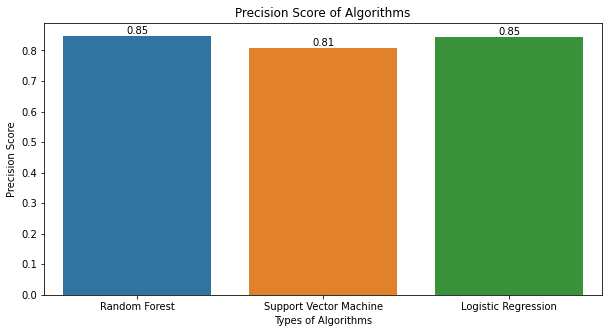

In [66]:
# Creating bar plot to show the Precision score
plt.figure(figsize=(10,5))
bp = sns.barplot(x = algorithms,y = [rf_prec, svm_prec, lr_prec])
bp.bar_label(container=bp.containers[0], labels=[round(rf_prec, 2), 
                                                 round(svm_prec, 2), round(lr_prec, 2)])

plt.xlabel("Types of Algorithms")
plt.ylabel("Precision Score")
plt.title('Precision Score of Algorithms')

## 4.5 Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix of Random Forest Classifier')

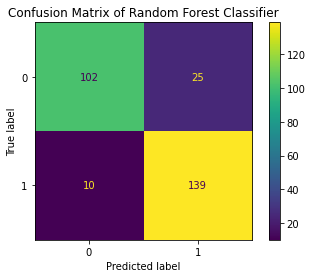

In [67]:
cm = confusion_matrix(heart_y_test, rf_pred_y)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_clf.classes_).plot()
plt.title("Confusion Matrix of Random Forest Classifier")

Text(0.5, 1.0, 'Confusion Matrix of SVM Classifier')

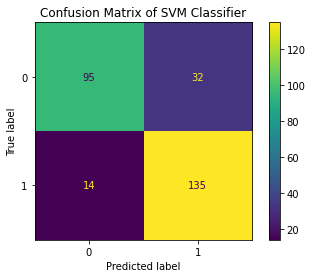

In [68]:
cm = confusion_matrix(heart_y_test, svm_pred_y)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = svm_clf.classes_).plot()
plt.title("Confusion Matrix of SVM Classifier")

Text(0.5, 1.0, 'Confusion Matrix of Logistic Regression Classifier')

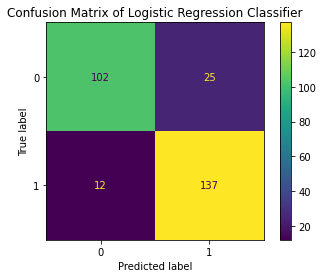

In [69]:
cm = confusion_matrix(heart_y_test, lr_pred_y)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = lr_clf.classes_).plot()
plt.title("Confusion Matrix of Logistic Regression Classifier")

From the confusion matrix, we could see SVM perform worst at it has the lowest value on the diagonal. Logistic Regression has same number of mistake (25) with Random Forest in predicting normal people as people who have heart disease. Logistic Regression make slightly more mistake in predicting heart disease patient as normal compared to Random Forest.

## 4.6 Feature Weightage/Importance

Text(0.5, 0, 'Importances')

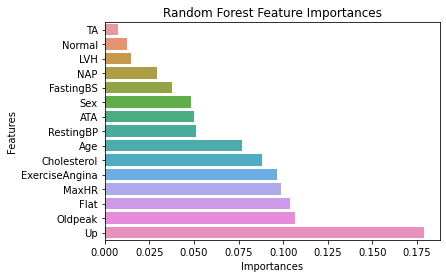

In [70]:
# Creating bar plot to show the Feature Importance in Random Forest
sorted_index = rf_clf.feature_importances_.argsort()
sns.barplot(y = heart_X_train.columns[sorted_index], 
            x = rf_clf.feature_importances_[sorted_index])
plt.ylabel("Features")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importances")